In [10]:
import torch
import numpy
import matplotlib.pyplot as plt

from dataset_mnist import *

from sklearn.manifold import TSNE


## augmentations
- random tile masking - zeroing random rectangular areas
- aditive gaussian noise
- random color inversion (negative)
- random flips, vertical, horizontal

In [11]:

def aug_random_apply(x, aug_func, p = 0.25): 
    c = (torch.rand((x.shape[0], 1, 1, 1)) < p).float()
    return (1.0 - c)*x + c*aug_func(x) 

'''
random tile masking
'''
def aug_random_tiles(x, max_loops = 4, p_base=0.1): 
    loops   = numpy.random.randint(0, max_loops+1)

    p       = p_base/((2*loops + 1)**2)

    mask    = (torch.rand((x.shape[0], 1, x.shape[2], x.shape[3])) < p).float()

    pool    = torch.nn.MaxPool2d(3, stride=1, padding=1)

    for i in range(loops):
        mask = pool(mask)

    mask = (1.0 - mask.to(x.device))
    return x*mask

'''
random gaussian noise
'''
def aug_noise(x): 
    return x + 0.1*torch.randn_like(x)
   
'''
negative
'''
def aug_inverse(x): 
    return 1.0 - x

'''
flips
'''
def aug_flip_h(x): 
    return torch.flip(x, dims=(3, ))

def aug_flip_v(x): 
    return torch.flip(x, dims=(2, ))
    

## dataset
- sample random batch x, y = dataset.get_batch(batch_size), 
- x input with shape (batch_size, 1, 28, 28)
- y labels with shape (batch_size, ) (not used)

- execute two sets of augmentation and plot augmented example

x =  torch.Size([128, 1, 28, 28]) tensor(0.1269) tensor(0.3038) tensor(1.)


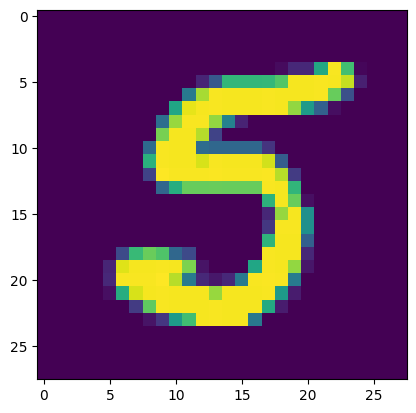

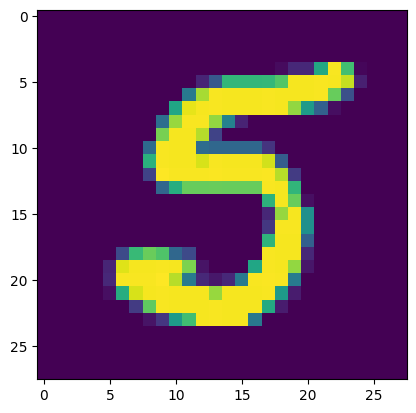

In [12]:
dataset = DatasetMnist()
batch_size = 128

x, y = dataset.get_batch(batch_size)

print("x = ", x.shape, x.mean(), x.std(), x.max())

xa = x.clone()
xb = x.clone()

#augmented batch example 
xa = aug_random_apply(xa, aug_random_tiles)
xb = aug_random_apply(xb, aug_random_tiles)

xa = aug_random_apply(xa, aug_noise)
xb = aug_random_apply(xb, aug_noise)

#xa = aug_random_apply(xa, aug_inverse)
#xb = aug_random_apply(xb, aug_inverse)

#xa = aug_random_apply(xa, aug_flip_h)
#xb = aug_random_apply(xb, aug_flip_h)

#xa = aug_random_apply(xa, aug_flip_v)
#xb = aug_random_apply(xb, aug_flip_v)

plt.imshow(xa[0][0].detach().cpu().numpy())
plt.show()
plt.imshow(xb[0][0].detach().cpu().numpy())
plt.show()


# model creating
- small conv model, 3 conv layers, two FC, provides output features
- ortohogonal init seems to be optimal weight init
- strided convs instead of obsolete poolings

In [13]:
'''
small conv model
'''
class Model(torch.nn.Module):
    def __init__(self, input_shape, features_count):
        super(Model, self).__init__()

        fc_size = (input_shape[1]//4) * (input_shape[2]//4)

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(input_shape[0], 16, kernel_size=3, stride=1, padding=1),
            torch.nn.LeakyReLU(),    
            
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.LeakyReLU(),   
            
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.LeakyReLU(), 

            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            torch.nn.LeakyReLU(),  

            torch.nn.Flatten(),
             
            torch.nn.Linear(fc_size*128, 256),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(256, features_count)
        ) 

        for i in range(len(self.model)):
            if hasattr(self.model[i], "weight"):
                torch.nn.init.orthogonal_(self.model[i].weight, 2**0.5)
                torch.nn.init.zeros_(self.model[i].bias)

    def forward(self, x): 
        return self.model(x) 
     

#create model
features_count = 128
model = Model(dataset.input_shape, features_count)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

Model(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=6272, out_features=256, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Linear(in_features=256, out_features=128, bias=True)
  )
)


## vicreg loss - non contrastive self supervised loss

- similarity, **sim_loss** : makes same inputs close
- variance, **std_za**, **std_za** : batch-wise variance, prevent collapsing, forces model to generate unique features for every different input
- covariance, **cov_za**, **cov_zb** : element-wise (feature-wise) decorrelation, forces model to generate unique features - output from model within single input are not correlate, a.k.a : each features output (each of 256 signals) gives unique infomation

In [14]:
def _off_diagonal(x):
    mask = 1.0 - torch.eye(x.shape[0], device=x.device)
    return x*mask 

def vicreg_loss_func(za, zb):
    eps = 0.0001 
 
    # invariance loss
    sim_loss = ((za - zb)**2).mean()

    # variance loss
    std_za = torch.sqrt(za.var(dim=0) + eps)
    std_zb = torch.sqrt(zb.var(dim=0) + eps) 
    
    std_loss = torch.mean(torch.relu(1.0 - std_za)) 
    std_loss+= torch.mean(torch.relu(1.0 - std_zb))
   
    # covariance loss 
    za_norm = za - za.mean(dim=0)
    zb_norm = zb - zb.mean(dim=0)
    cov_za = (za_norm.T @ za_norm) / (za.shape[0] - 1.0)
    cov_zb = (zb_norm.T @ zb_norm) / (zb.shape[0] - 1.0)
    
    cov_loss = _off_diagonal(cov_za).pow_(2).sum()/za.shape[1] 
    cov_loss+= _off_diagonal(cov_zb).pow_(2).sum()/zb.shape[1]

    # total vicreg loss
    loss = 1.0*sim_loss + 1.0*std_loss + (1.0/25.0)*cov_loss

    return loss


## training loop

In [15]:
'''
#training
steps_count = len(dataset)//batch_size
for i in range(steps_count):

    #get random batch
    x, _ = dataset.get_batch(batch_size)
    
    xa = x.clone()
    xb = x.clone()

    #create augmented inputs
    xa = aug_random_apply(xa, aug_random_tiles)
    xb = aug_random_apply(xb, aug_random_tiles)

    xa = aug_random_apply(xa, aug_noise)
    xb = aug_random_apply(xb, aug_noise)

    #xa = aug_random_apply(xa, aug_inverse)
    #xb = aug_random_apply(xb, aug_inverse)

    #xa = aug_random_apply(xa, aug_flip_h) 
    #xb = aug_random_apply(xb, aug_flip_h)

    #xa = aug_random_apply(xa, aug_flip_v)
    #xb = aug_random_apply(xb, aug_flip_v)

    #obtain features
    za = model(xa)
    zb = model(xb)

    #compute loss
    loss = vicreg_loss_func(za, zb)

    #optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(i, steps_count, loss)

torch.save(model.state_dict(), "trained/model_mnist_3.pt")
'''

'\n#training\nsteps_count = len(dataset)//batch_size\nfor i in range(steps_count):\n\n    #get random batch\n    x, _ = dataset.get_batch(batch_size)\n    \n    xa = x.clone()\n    xb = x.clone()\n\n    #create augmented inputs\n    xa = aug_random_apply(xa, aug_random_tiles)\n    xb = aug_random_apply(xb, aug_random_tiles)\n\n    xa = aug_random_apply(xa, aug_noise)\n    xb = aug_random_apply(xb, aug_noise)\n\n    #xa = aug_random_apply(xa, aug_inverse)\n    #xb = aug_random_apply(xb, aug_inverse)\n\n    #xa = aug_random_apply(xa, aug_flip_h) \n    #xb = aug_random_apply(xb, aug_flip_h)\n\n    #xa = aug_random_apply(xa, aug_flip_v)\n    #xb = aug_random_apply(xb, aug_flip_v)\n\n    #obtain features\n    za = model(xa)\n    zb = model(xb)\n\n    #compute loss\n    loss = vicreg_loss_func(za, zb)\n\n    #optimizer\n    optimizer.zero_grad()\n    loss.backward()\n    optimizer.step()\n\n    print(i, steps_count, loss)\n\ntorch.save(model.state_dict(), "trained/model_mnist_3.pt")\n'

## model testing for similarity detection

- here four batches are sampled, each containing only numbers : 0, 1, 2 and 3
- batches are concatenated into one big batch
- obtained model features
- similarity of z are computed (z@z.T), provide matrix (4 * batch_size, 4 * batch_size)
- visualised result show how similar features are generated for similar inputs

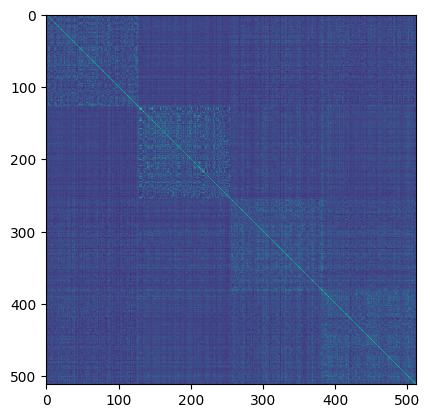

In [16]:

#create model and load weights
model = Model(dataset.input_shape, features_count)
model.load_state_dict(torch.load("trained/model_mnist_3.pt", map_location = "cpu"))
model.eval()


batch_size = 128

#sample only zeros from dataset
x0 = dataset.get_batch_class(batch_size, 0)

#sample only ones from dataset
x1 = dataset.get_batch_class(batch_size, 1)

#sample only sevens from dataset
x2 = dataset.get_batch_class(batch_size, 2)

#sample only nines from dataset
x3 = dataset.get_batch_class(batch_size, 3)

#creare one big batch
x = torch.concatenate([x0, x1, x2, x3], dim=0)

#obtain features
z = model(x) 

#vectors dot product, each by each
similarity = z@z.T


plt.imshow(similarity.detach().cpu().numpy())
plt.show()


## features projection

2D visualisation of trained feature space

- sample random batch
- use T-SNE to project 128D space into 2D
- plot it, with coloring by class ID


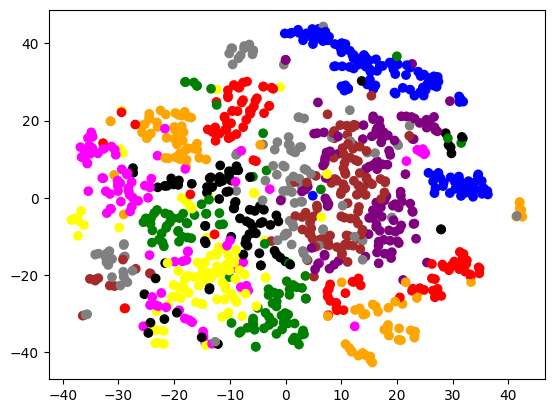

In [17]:
x, y = dataset.get_batch(1024)

y = y.detach().cpu().numpy()
y = numpy.array(y, dtype=int)

z = model(x) 

z = z.detach().cpu().numpy()

z_proj = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(z)


colormap = numpy.array(["red","blue","green","yellow","gray","magenta","orange","purple","black","brown"])

plt.scatter(z_proj[:, 0], z_proj[:, 1], c=colormap[y])
plt.show()

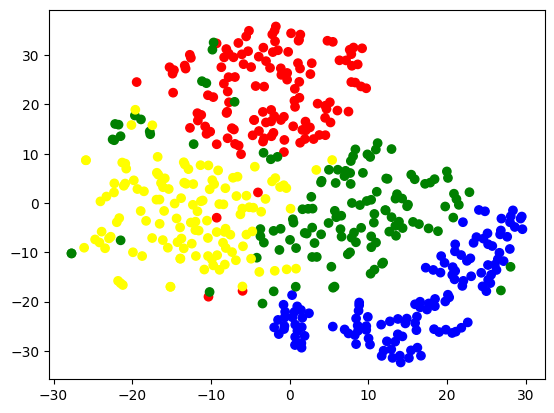

In [18]:
x0 = dataset.get_batch_class(128, 0)
y0 = 0*torch.ones((x0.shape[0],), dtype=int)

x1 = dataset.get_batch_class(128, 1)
y1 = 1*torch.ones((x1.shape[0],), dtype=int)

x2 = dataset.get_batch_class(128, 2)
y2 = 2*torch.ones((x2.shape[0],), dtype=int)

x3 = dataset.get_batch_class(128, 3)
y3 = 3*torch.ones((x3.shape[0],), dtype=int)

x = torch.concatenate([x0, x1, x2, x3], dim=0)
y = torch.concatenate([y0, y1, y2, y3], dim=0) 

y = y.detach().cpu().numpy()
y = numpy.array(y, dtype=int)

z = model(x) 

z = z.detach().cpu().numpy()

z_proj = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(z)


colormap = numpy.array(["red","blue","green","yellow"])

plt.scatter(z_proj[:, 0], z_proj[:, 1], c=colormap[y])
plt.show()

# TODO 

## create anomaly detection

- context is reference input (batch with size e.g. 256), containing only 0s (dataset.get_batch_class(batch_size, 0))
- unknow input is another batch, containing only 1s or 0s (fo testing)
- use z-space to recognize if on unknow input is presented 1s or 0s